## Import Libraries and data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from scipy import stats
from tqdm import tqdm

from imblearn.over_sampling import SMOTE, ADASYN

from utils import clean_text, calculate_churn_risk_score

In [3]:
df = pd.read_csv('df_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


In [4]:
with open(r'.\dumps\categorical_columns.pkl', 'rb') as f:
    categorical_cols = pickle.load(f)

with open(r'.\dumps\numeric_columns.pkl', 'rb') as f:
    numeric_cols = pickle.load(f)

In [5]:
df[categorical_cols] = df[categorical_cols].astype(str)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   object 
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 


### Split the data

In [8]:
X = df.drop(['Churn'], axis=1) # Features
y = df['Churn']   # Target

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify = y)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('train data shape', X_train.shape, y_train.shape)
print('test data shape', X_test.shape, y_test.shape)

train data shape (5625, 19) (5625,)
test data shape (1407, 19) (1407,)


In [10]:
with open(r'.\data_for_model\test\test_data.pkl','wb') as f:
    pickle.dump([X_test, y_test], f)

## Preprocessing

### Target variable

In [13]:
target_mapping = {'yes':1, 'no':0}
y_train = y_train.map(target_mapping)
y_test = y_test.map(target_mapping)

In [14]:
with open(r'.\dumps\target_mapping.pkl', 'wb') as f:
    pickle.dump(target_mapping, f)

### Numeric variables

**Feature Engineering**

#### **Feature:** Charges_to_tenure_ratio
    Charges_to_tenure_ratio = monthlyCharges / tenure

In [17]:
X_train['Charges_to_tenure_ratio'] = X_train['MonthlyCharges'] / X_train['tenure']

<Axes: xlabel='Charges_to_tenure_ratio', ylabel='Count'>

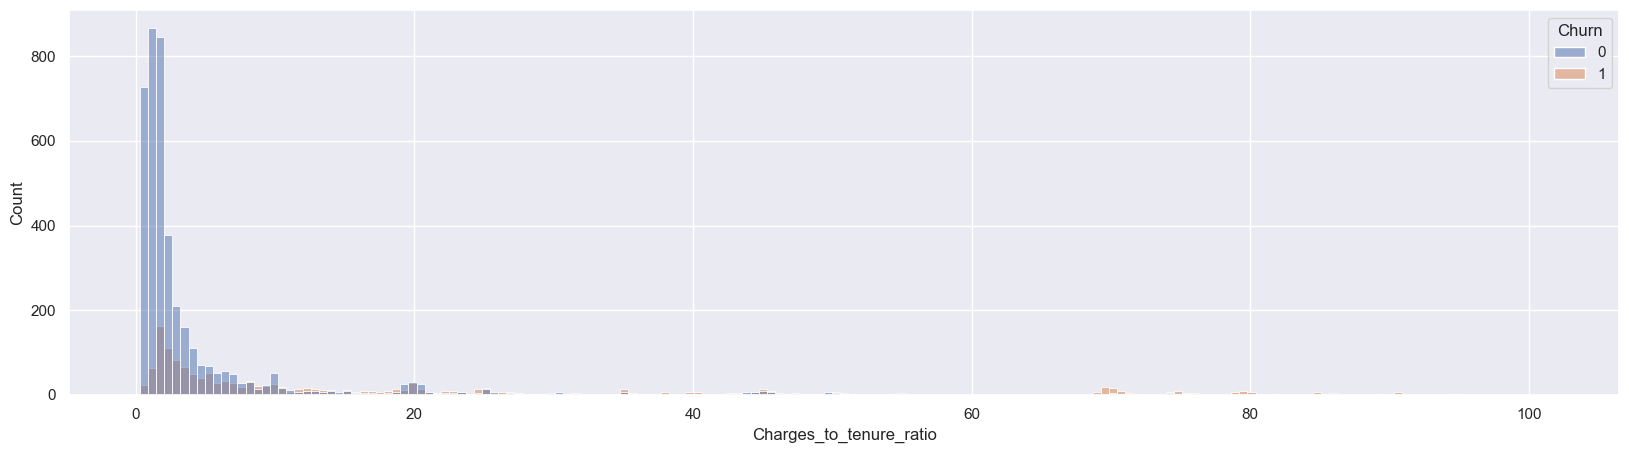

In [18]:
plt.figure(figsize=(20,5))

df_ct = pd.concat([X_train,y_train],axis=1)

sns.histplot(data = df_ct, x='Charges_to_tenure_ratio', hue='Churn')

<Axes: xlabel='Charges_to_tenure_ratio', ylabel='Count'>

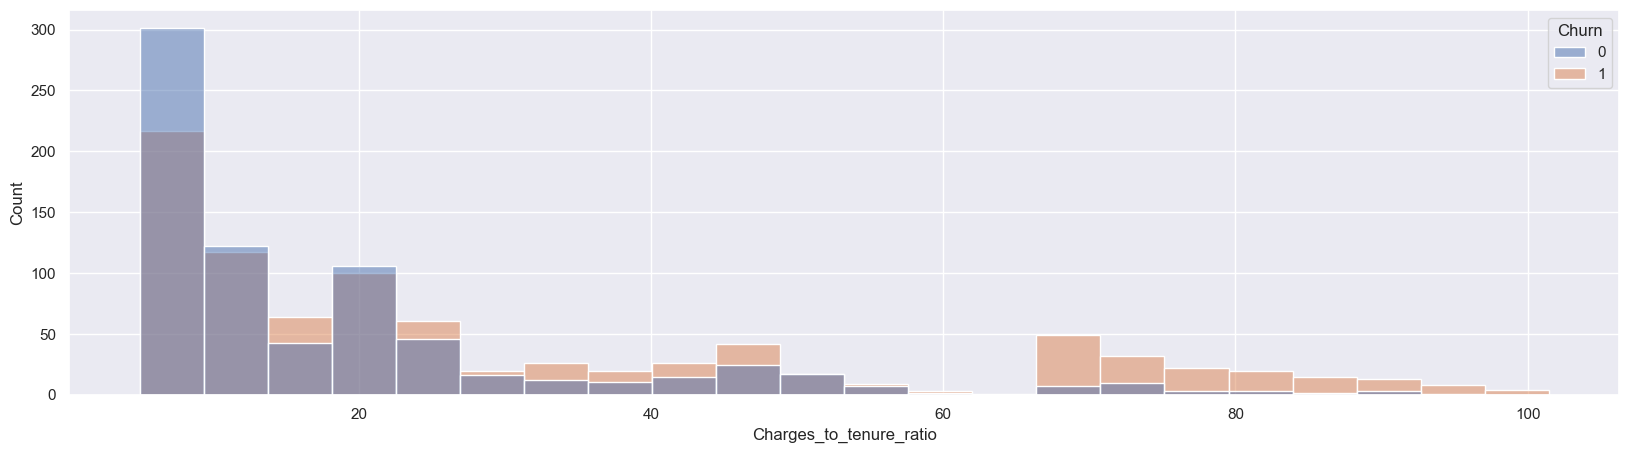

In [19]:
plt.figure(figsize=(20,5))
sns.histplot(data = df_ct[X_train['Charges_to_tenure_ratio'] > 5], x='Charges_to_tenure_ratio', hue='Churn')

We can see that churn rate is high as charges to tenure ratio is high

KstestResult(statistic=0.350820629059606, pvalue=0.0, statistic_location=0.10619780992629814, statistic_sign=-1) 



<Axes: xlabel='Charges_to_tenure_ratio_transformed', ylabel='Count'>

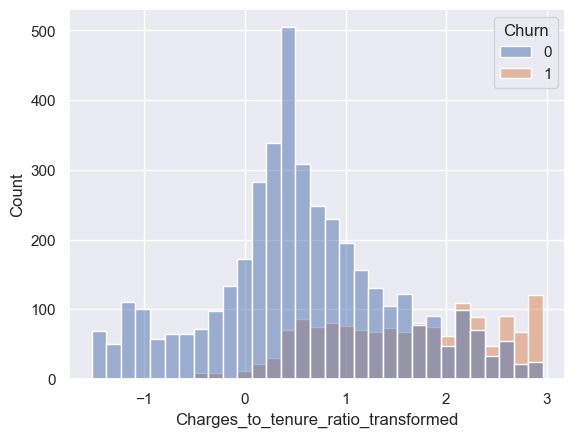

In [21]:
X_train['Charges_to_tenure_ratio_transformed'], lambda_best_fit = stats.boxcox(X_train['Charges_to_tenure_ratio'])
print(stats.kstest(X_train['Charges_to_tenure_ratio_transformed'], 'norm'), '\n')

sns.histplot(data= pd.concat([X_train,y_train], axis=1),x='Charges_to_tenure_ratio_transformed', hue='Churn')

KstestResult(statistic=0.5985254526988925, pvalue=0.0, statistic_location=0.5980695318577031, statistic_sign=-1) 



<Axes: xlabel='Charges_to_tenure_ratio_transformed', ylabel='Count'>

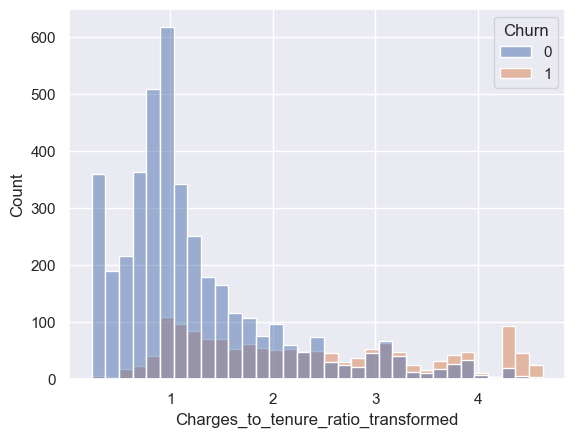

In [22]:
X_train['Charges_to_tenure_ratio_transformed'] = np.log(X_train['Charges_to_tenure_ratio']+1)
print(stats.kstest(X_train['Charges_to_tenure_ratio_transformed'], 'norm'), '\n')

sns.histplot(data= pd.concat([X_train,y_train], axis=1),x='Charges_to_tenure_ratio_transformed', hue='Churn')

KstestResult(statistic=0.0014086086086085858, pvalue=1.0, statistic_location=1.2075322646773317, statistic_sign=-1) 



<Axes: xlabel='Charges_to_tenure_ratio_transformed', ylabel='Count'>

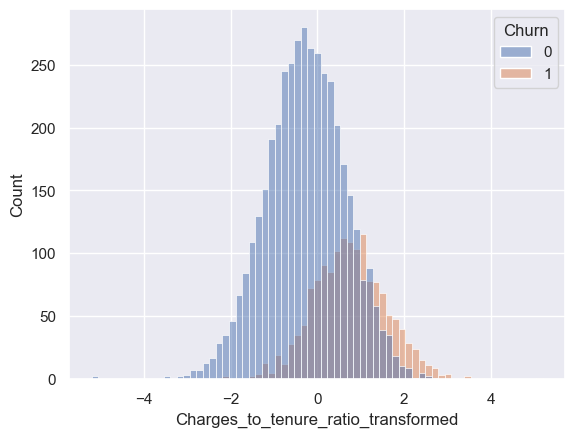

In [23]:
transformer = QuantileTransformer(output_distribution='normal')

X_train['Charges_to_tenure_ratio_transformed'] = transformer.fit_transform(X_train[['Charges_to_tenure_ratio']])
print(stats.kstest(X_train['Charges_to_tenure_ratio_transformed'], 'norm'),'\n')

sns.histplot(data= pd.concat([X_train,y_train], axis=1),x='Charges_to_tenure_ratio_transformed', hue='Churn')

In [24]:
with open(r'.\dumps\Charges_to_tenure_ratio_transformer.pkl','wb') as f:
    pickle.dump(transformer,f)

#### **Feature:** tenure

KstestResult(statistic=0.8276210404806863, pvalue=0.0, statistic_location=1.9420115934298912, statistic_sign=-1) 



<Axes: xlabel='tenure_transformed', ylabel='Count'>

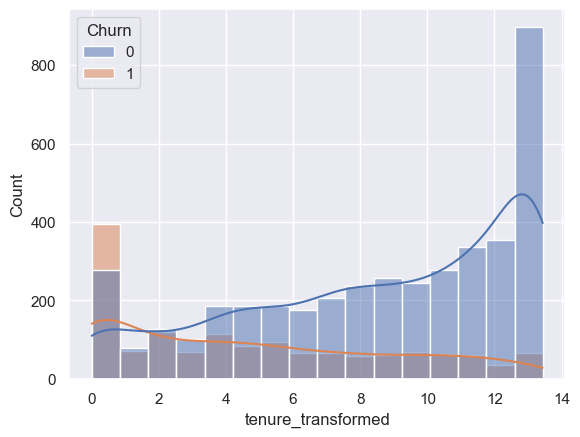

In [26]:
X_train['tenure_transformed'], lambda_best_fit = stats.boxcox(X_train['tenure'])
print(stats.kstest(X_train['tenure_transformed'], 'norm'), '\n')

sns.histplot(data= pd.concat([X_train,y_train], axis=1),x='tenure_transformed', hue='Churn', kde=True)

KstestResult(statistic=0.08604434444444467, pvalue=1.1091687364170866e-36, statistic_location=-5.199337582605575, statistic_sign=1) 



<Axes: xlabel='tenure_transformed', ylabel='Count'>

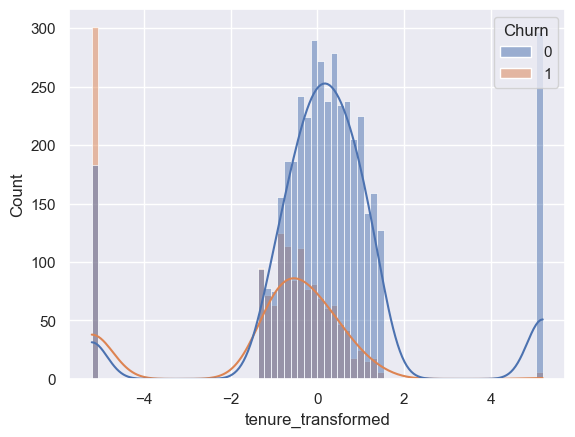

In [27]:
transformer = QuantileTransformer(output_distribution='normal')

X_train['tenure_transformed']= transformer.fit_transform(X_train[['tenure']])
print(stats.kstest(X_train['tenure_transformed'], 'norm'), '\n')

sns.histplot(data= pd.concat([X_train,y_train], axis=1),x='tenure_transformed', hue='Churn', kde=True)

In [28]:
with open(r'.\dumps\tenure_transformer.pkl','wb') as f:
    pickle.dump(transformer, f)

#### **Feature:** MonthlyCharges

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=15.081610073556906, statistic_sign=-1) 



<Axes: xlabel='MonthlyCharges_transformed', ylabel='Count'>

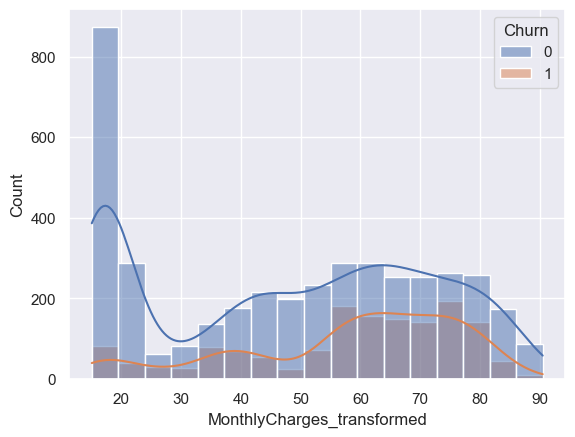

In [30]:
X_train['MonthlyCharges_transformed'], lambda_best_fit = stats.boxcox(X_train['MonthlyCharges'])
print(stats.kstest(X_train['MonthlyCharges_transformed'], 'norm'), '\n')

sns.histplot(data= pd.concat([X_train,y_train], axis=1),x='MonthlyCharges_transformed', hue='Churn', kde=True)

KstestResult(statistic=0.9984879281534768, pvalue=0.0, statistic_location=2.9652730660692823, statistic_sign=-1) 



<Axes: xlabel='MonthlyCharges_transformed', ylabel='Count'>

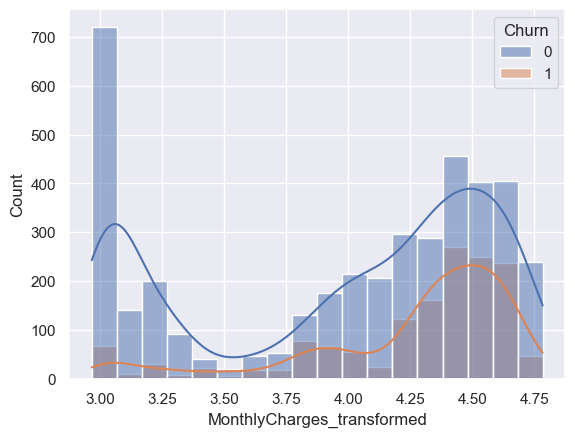

In [31]:
X_train['MonthlyCharges_transformed']= np.log(X_train['MonthlyCharges'] + 1)
print(stats.kstest(X_train['MonthlyCharges_transformed'], 'norm'), '\n')

sns.histplot(data= pd.concat([X_train,y_train], axis=1),x='MonthlyCharges_transformed', hue='Churn', kde=True)

KstestResult(statistic=0.004540540540540539, pvalue=0.9997991981694415, statistic_location=-1.3041214037998639, statistic_sign=-1) 



<Axes: xlabel='MonthlyCharges_transformed', ylabel='Count'>

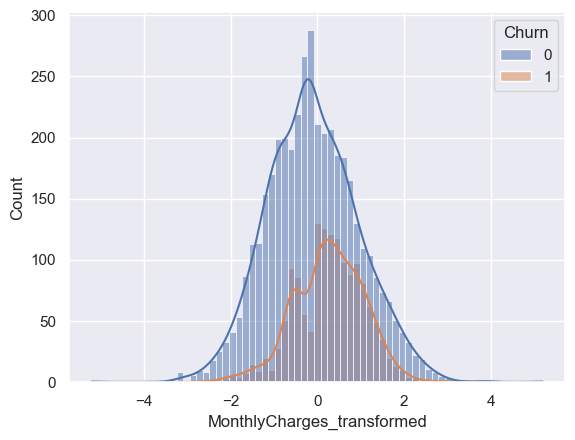

In [32]:
transformer = QuantileTransformer(output_distribution='normal')

X_train['MonthlyCharges_transformed']= transformer.fit_transform(X_train[['MonthlyCharges']])
print(stats.kstest(X_train['MonthlyCharges_transformed'], 'norm'), '\n')

sns.histplot(data= pd.concat([X_train,y_train], axis=1),x='MonthlyCharges_transformed', hue='Churn', kde=True)

In [33]:
with open(r'.\dumps\MonthlyCharges_transformer.pkl','wb') as f:
    pickle.dump(transformer, f)

#### **Feature:** TotalCharges

KstestResult(statistic=0.9999942393616292, pvalue=0.0, statistic_location=4.386455415146012, statistic_sign=-1) 



<Axes: xlabel='TotalCharges_transformed', ylabel='Count'>

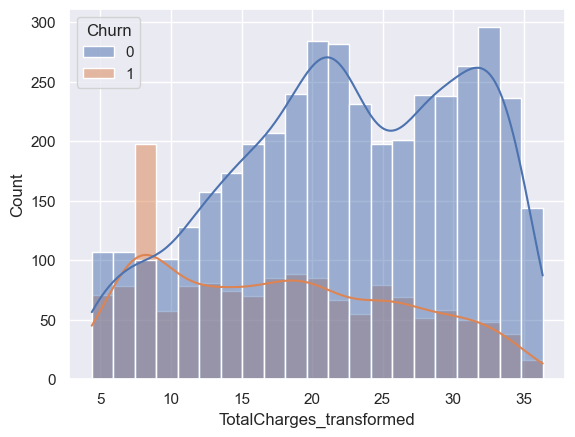

In [35]:
X_train['TotalCharges_transformed'], lambda_best_fit = stats.boxcox(X_train['TotalCharges'])
print(stats.kstest(X_train['TotalCharges_transformed'], 'norm'), '\n')

sns.histplot(data= pd.concat([X_train,y_train], axis=1),x='TotalCharges_transformed', hue='Churn', kde=True)

<Axes: xlabel='TotalCharges_transformed', ylabel='Count'>

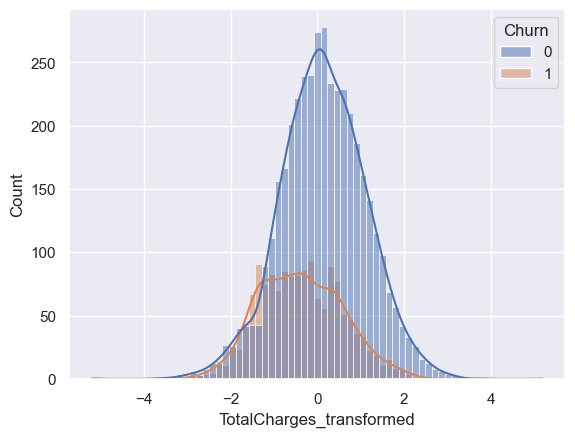

In [36]:
transformer = QuantileTransformer(output_distribution='normal')

X_train['TotalCharges_transformed'] = transformer.fit_transform(X_train[['TotalCharges']])

sns.histplot(data=pd.concat([X_train,y_train],axis=1), x='TotalCharges_transformed', hue= 'Churn', kde=True)

In [37]:
with open(r'.\dumps\TotalCharges_transformer.pkl','wb') as f:
    pickle.dump(transformer, f)

#### Additional FE features

In [39]:
# Tenure Binning
X_train.loc[(X_train["tenure"] <= 12), "New_tenure_Year"] = "0_1_Year"
X_train.loc[(X_train["tenure"] > 12) & (X_train["tenure"] <= 24), "New_tenure_Year"] = "1_2_Year"
X_train.loc[(X_train["tenure"] > 24) & (X_train["tenure"] <= 36), "New_tenure_Year"] = "2_3_Year"
X_train.loc[(X_train["tenure"] > 36) & (X_train["tenure"] <= 48), "New_tenure_Year"] = "3_4_Year"
X_train.loc[(X_train["tenure"] > 48) & (X_train["tenure"] <= 60), "New_tenure_Year"] = "4_5_Year"
X_train.loc[(X_train["tenure"] > 60) & (X_train["tenure"] <= 72), "New_tenure_Year"] = "5_6_Year"

In [40]:
# People who do not receive any support, backup or protection
X_train["New_Support"] = X_train.apply(lambda x: '1' if (x["OnlineBackup"] != "yes") or (x["DeviceProtection"] != "yes") or (x["TechSupport"] != "yes") else '0', axis=1)

In [41]:
X_train['New_Churn_Risk_Score'] = X_train.apply(calculate_churn_risk_score, axis=1)

In [42]:
numeric_FE_columns = ['Charges_to_tenure_ratio', 'Charges_to_tenure_ratio_transformed',
       'tenure_transformed', 'MonthlyCharges_transformed',
       'TotalCharges_transformed', 'New_Churn_Risk_Score']

with open(r'.\dumps\numeric_FE_columns.pkl', 'wb') as f:
    pickle.dump(numeric_FE_columns, f)

In [43]:
categorical_FE_cols = ['New_Support', 'New_tenure_Year']

with open(r'.\dumps\categorical_FE_columns.pkl', 'wb') as f:
    pickle.dump(categorical_FE_cols, f)

### Categorical Variables

In [45]:
one_hot_features = []
mapping_features = []
for feature in categorical_cols + categorical_FE_cols:
    if len(X_train[feature].unique()) == 2:
        mapping_features.append(feature)
    else:
        one_hot_features.append(feature)
    print(feature, ' : ', X_train[feature].unique())


with open(r'.\dumps\one_hot_features.pkl', 'wb') as f:
    pickle.dump(one_hot_features, f)

with open(r'.\dumps\mapping_features.pkl', 'wb') as f:
    pickle.dump(mapping_features, f)

gender  :  ['male' 'female']
SeniorCitizen  :  ['0' '1']
Partner  :  ['yes' 'no']
Dependents  :  ['yes' 'no']
PhoneService  :  ['yes' 'no']
MultipleLines  :  ['yes' 'no_phone_service' 'no']
InternetService  :  ['fiber_optic' 'dsl' 'no']
OnlineSecurity  :  ['yes' 'no' 'no_internet_service']
OnlineBackup  :  ['yes' 'no' 'no_internet_service']
DeviceProtection  :  ['yes' 'no' 'no_internet_service']
TechSupport  :  ['yes' 'no' 'no_internet_service']
StreamingTV  :  ['no' 'yes' 'no_internet_service']
StreamingMovies  :  ['no' 'yes' 'no_internet_service']
Contract  :  ['two_year' 'month_to_month' 'one_year']
PaperlessBilling  :  ['no' 'yes']
PaymentMethod  :  ['credit_card' 'electronic_check' 'bank_transfer' 'mailed_check']
New_Support  :  ['0' '1']
New_tenure_Year  :  ['5_6_Year' '2_3_Year' '0_1_Year' '4_5_Year' '1_2_Year' '3_4_Year']


**Observation:** 

    - Features with just 2 values can be mapped to binary values
    - Since, cardinality is low for other features, we will use One-Hot Encoding

#### Mapping

In [48]:
mapping = {'female': 0, 'male': 1,
          'yes' : 1, 'no' : 0,
          '1' : 1, '0' : 0}

for feature in tqdm(mapping_features):
    X_train[feature] = X_train[feature].map(mapping).astype(int)

with open(r'.\dumps\mapping.pkl', 'wb') as f:
    pickle.dump(mapping, f)

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1163.38it/s]


#### One-Hot Encoding

In [50]:
encoder = OneHotEncoder(sparse=False)

ohe_features_encoded = pd.DataFrame(encoder.fit_transform(X_train[one_hot_features]), columns= encoder.get_feature_names_out())
ohe_features_encoded = ohe_features_encoded.astype(int)

one_hot_encoder_feature_names = encoder.get_feature_names_out().tolist()

with open(r'.\dumps\one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

with open(r'.\dumps\one_hot_encoder_feature_names.pkl', 'wb') as f:
    pickle.dump(one_hot_encoder_feature_names, f)

In [51]:
ohe_features_encoded.head(2)

,MultipleLines_no,MultipleLines_no_phone_service,MultipleLines_yes,InternetService_dsl,InternetService_fiber_optic,InternetService_no,OnlineSecurity_no,OnlineSecurity_no_internet_service,OnlineSecurity_yes,OnlineBackup_no,...,PaymentMethod_bank_transfer,PaymentMethod_credit_card,PaymentMethod_electronic_check,PaymentMethod_mailed_check,New_tenure_Year_0_1_Year,New_tenure_Year_1_2_Year,New_tenure_Year_2_3_Year,New_tenure_Year_3_4_Year,New_tenure_Year_4_5_Year,New_tenure_Year_5_6_Year
0,0,0,1,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,0,1,0,1,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0


### Final Features

In [53]:
X_train_imb = pd.concat([X_train[numeric_cols + numeric_FE_columns + mapping_features], ohe_features_encoded], axis=1)
X_train_imb.shape, y_train.shape

((5625, 53), (5625,))

In [54]:
with open(r'.\data_for_model\train\0_imb_data.pkl', 'wb') as f:
    pickle.dump([X_train_imb, y_train], f)

### Balancing the data

#### SMOTE

In [57]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imb, y_train)
print('shape of X_resampled and y_resampled:', X_train_smote.shape, y_train_smote.shape)

y_train_smote.value_counts()

shape of X_resampled and y_resampled: (8260, 53) (8260,)


Churn
0    4130
1    4130
Name: count, dtype: int64

In [58]:
with open(r'.\data_for_model\train\1_smote_data.pkl', 'wb') as f:
    pickle.dump([X_train_smote, y_train_smote], f)

#### ADASYN

In [60]:
adasyn = ADASYN(sampling_strategy='minority', random_state=42)

# Fit and transform the data
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_imb, y_train)
print('shape of X_resampled and y_resampled:', X_train_adasyn.shape, y_train_adasyn.shape)

y_train_adasyn.value_counts()

shape of X_resampled and y_resampled: (8308, 53) (8308,)


Churn
1    4178
0    4130
Name: count, dtype: int64

In [61]:
with open(r'.\data_for_model\train\2_adasyn_data.pkl', 'wb') as f:
    pickle.dump([X_train_adasyn, y_train_adasyn], f)

**3 datasets**

1. Imbalanced data
2. SMOTE balanced data
3. ADASYN balanced data

### Scaling

In [64]:
num_cols = numeric_cols + numeric_FE_columns

#### Standard Scaling

1. Imbalanced data

In [67]:
scaler = StandardScaler()

num_std = pd.DataFrame(scaler.fit_transform(X_train_imb[num_cols]), columns=num_cols)

X_train_imb_std = pd.concat([num_std, X_train_imb[mapping_features], X_train_imb[one_hot_encoder_feature_names]], axis=1)

with open(r'.\dumps\0_imb_standardscaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open(r'.\data_for_model\train\0_imb_std_data.pkl', 'wb') as f:
    pickle.dump([X_train_imb_std, y_train], f)

2. SMOTE data


In [69]:
scaler = StandardScaler()

num_std = pd.DataFrame(scaler.fit_transform(X_train_smote[num_cols]), columns=num_cols)

X_train_smote_std = pd.concat([num_std, X_train_smote[mapping_features], X_train_smote[one_hot_encoder_feature_names]], axis=1)

with open(r'.\dumps\1_smote_standardscaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open(r'.\data_for_model\train\1_smote_std_data.pkl', 'wb') as f:
    pickle.dump([X_train_smote_std, y_train_smote], f)

3. ADASYN data

In [71]:
scaler = StandardScaler()

num_std = pd.DataFrame(scaler.fit_transform(X_train_adasyn[num_cols]), columns=num_cols)

X_train_adasyn_std = pd.concat([num_std, X_train_adasyn[mapping_features], X_train_adasyn[one_hot_encoder_feature_names]], axis=1)

with open(r'.\dumps\2_adasyn_standardscaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open(r'.\data_for_model\train\2_adasyn_std_data.pkl', 'wb') as f:
    pickle.dump([X_train_adasyn_std, y_train_adasyn], f)

#### MinMaxScaling

1. Imbalanced data

In [74]:
scaler = MinMaxScaler()

num_mm = pd.DataFrame(scaler.fit_transform(X_train_imb[num_cols]), columns=num_cols)

X_train_imb_mm = pd.concat([num_mm, X_train_imb[mapping_features], X_train_imb[one_hot_encoder_feature_names]], axis=1)

with open(r'.\dumps\0_imb_minmaxscaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open(r'.\data_for_model\train\0_imb_minmax_data.pkl', 'wb') as f:
    pickle.dump([X_train_imb_mm, y_train], f)

2. SMOTE data

In [76]:
scaler = MinMaxScaler()

num_mm = pd.DataFrame(scaler.fit_transform(X_train_smote[num_cols]), columns=num_cols)

X_train_smote_mm = pd.concat([num_mm, X_train_smote[mapping_features], X_train_smote[one_hot_encoder_feature_names]], axis=1)

with open(r'.\dumps\1_smote_minmaxscaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open(r'.\data_for_model\train\1_smote_minmax_data.pkl', 'wb') as f:
    pickle.dump([X_train_smote_mm, y_train_smote], f)

3. ADASYN data

In [78]:
scaler = MinMaxScaler()

num_mm = pd.DataFrame(scaler.fit_transform(X_train_adasyn[num_cols]), columns=num_cols)

X_train_adasyn_mm = pd.concat([num_mm, X_train_adasyn[mapping_features], X_train_adasyn[one_hot_encoder_feature_names]], axis=1)

with open(r'.\dumps\2_adasyn_minmaxscaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open(r'.\data_for_model\train\2_adasyn_minmax_data.pkl', 'wb') as f:
    pickle.dump([X_train_adasyn_mm, y_train_adasyn], f)